In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc as auc_calc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder,KBinsDiscretizer
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,precision_recall_curve
from ucimlrepo import fetch_ucirepo 
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


# データ整備

In [2]:
# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape,test.shape)
train["data"]="train"
test["data"]="test"
target="Response"
test[target]=-1
data=pd.concat([train.sample(frac= 0.1),test]).reset_index(drop=True)

(11504798, 12) (7669866, 11)


In [4]:
def converting_datatypes(data_input):
    df = data_input.copy()
    try:
        # Converting data types
        df['Gender'] = df['Gender'].astype('category')
        df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
        df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')
        df['Age'] = df['Age'].astype('int8')
        df['Driving_License'] = df['Driving_License'].astype('int8')
        df['Region_Code'] = df['Region_Code'].astype('int8')
        df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
        df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
        df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
        df['Vintage'] = df['Vintage'].astype('int16')
        df['Response'] = df['Response'].astype('int8')
        print(df.info(memory_usage='deep'))
    except KeyError as e:
        print(f"Error: {e} not found in DataFrame")
    except Exception as e:
        print(f"An error occurred: {e}")
    return df
data=converting_datatypes(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8820346 entries, 0 to 8820345
Data columns (total 13 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int8    
 3   Driving_License       int8    
 4   Region_Code           int8    
 5   Previously_Insured    int8    
 6   Vehicle_Age           category
 7   Vehicle_Damage        category
 8   Annual_Premium        int32   
 9   Policy_Sales_Channel  int16   
 10  Vintage               int16   
 11  Response              int8    
 12  data                  object  
dtypes: category(3), int16(2), int32(1), int64(1), int8(5), object(1)
memory usage: 716.1 MB
None


In [5]:
cat_col=["Gender","Driving_License","Region_Code",
        "Previously_Insured","Vehicle_Age","Vehicle_Damage","Policy_Sales_Channel",
        ]
num_col=["Age","Annual_Premium","Vintage"]

In [6]:
data["Age_segment"]=pd.cut(data["Age"],bins=np.arange(20,100,10),labels=np.arange(20,90,10),right=False)
data['Annual_Premium_segment']=np.where(data["Annual_Premium"]<10000,1,0)
cat_col.append("Age_segment")
cat_col.append('Annual_Premium_segment')

In [7]:
def cat_feature(data_input):
    global cat_col
    df=data_input.copy()
    
    for i,i_col in enumerate(cat_col):
        for j,j_col in enumerate(cat_col):
            df[f"{i_col}_{j_col}"]=df[f"{i_col}"].astype(str)+"_"+df[f"{j_col}"].astype(str)
    cat_col+=list(set(df.columns)-set(data_input.columns))
    return df
data_new_feature=cat_feature(data)

In [ ]:
# def cat_feature(data_input,col):
#     global cat_col
#     df=data_input.copy()
#     df['Policy_Region'] = df['Policy_Sales_Channel'].astype(str) + '_' + df['Region_Code'].astype(str)
#     df['Vehicle_Age_License'] = df['Vehicle_Age'].astype(str) + '_' + df['Driving_License'].astype(str)        
#     df['Vehicle_Age_Damage'] = df['Vehicle_Age'].astype(str) + '_' + df['Vehicle_Damage'].astype(str)
#     df['Region_Code_Vage'] = df['Vehicle_Age'].astype(str) + '_' + df['Region_Code'].astype(str)
#     df['Prev_insured_vehicle_damage'] = df['Previously_Insured'].astype(str) + "_" + df['Vehicle_Damage'].astype(str)
#     df['InsuranceLicense'] = df['Driving_License'].astype('str') + df['Previously_Insured'].astype('str')
#     df['InsuranceGender'] = df['Gender'].astype('str') + df['Previously_Insured'].astype('str')
#     for i,i_col in enumerate(cat_col):
#             df[f"{col}_{i_col}"]=df[f"{col}"].astype(str)+"_"+df[f"{i_col}"].astype(str)
#     cat_col+=list(set(df.columns)-set(data_input.columns))
#     return df
# data_new_feature=cat_feature(data,cat_col[4])

In [ ]:
df_Channel_Code=pd.DataFrame(data.groupby('Policy_Sales_Channel').size().rename("num")).reset_index()
for col in ['Gender', 'Age_segment', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium_segment']:
    tmp=data.groupby('Policy_Sales_Channel')[col].value_counts(normalize=True).unstack().fillna(0).astype("float64")
    tmp.columns=[f"Channel_and_{col}_"+str(_) for _ in tmp.columns]
    df_Channel_Code=pd.merge(df_Channel_Code,tmp.reset_index(),on='Policy_Sales_Channel',how="outer")
df_Channel_Code.drop(columns=["num"],inplace=True)

In [ ]:
df_Region_Code=pd.DataFrame(data.groupby("Region_Code").size().rename("num")).reset_index()
for col in ['Gender', 'Age_segment', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium_segment']:
    tmp=data.groupby('Region_Code')[col].value_counts(normalize=True).unstack().fillna(0).astype("float64")
    tmp.columns=[f"Region_and_{col}_"+str(_) for _ in tmp.columns]
    df_Region_Code=pd.merge(df_Region_Code,tmp.reset_index(),on="Region_Code",how="outer")
df_Region_Code.drop(columns=["num"],inplace=True)

In [ ]:

def new_features(data_input):
    df=data_input.copy()
    label_encoders = {}
    for col in cat_col:
        le= LabelEncoder()
        label_encoders[col] = le
        df[col] = le.fit_transform(df[col])
    return df,label_encoders
#data_new_feature,encoder_list=new_features(data)
data_new_feature,encoder_list=new_features(data_new_feature)

In [ ]:
def region_feature(data_input):
    global num_col
    df=data_input.copy()
    df=pd.merge(df,df_Region_Code,on="Region_Code",how="outer")
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df
data_new_feature=region_feature(data_new_feature)

In [ ]:
def channel_feature(data_input):
    global num_col
    df=data_input.copy()
    df=pd.merge(df,df_Channel_Code,on="Policy_Sales_Channel",how="outer")
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df
data_new_feature=channel_feature(data_new_feature)

In [ ]:
num_col

['Age', 'Annual_Premium', 'Vintage']

In [ ]:
cat_col

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

In [ ]:
def new_features2(data_input):
    global  num_col,cat_col
    df=data_input.copy()
    df['log_age'] = np.log(df['Age'])
    num_col.append("log_age")
    df['sqrt_premium'] = np.sqrt(df['Annual_Premium'])
    num_col.append("sqrt_premium")
    df['log_vintage'] = np.log(df['Vintage'])
    num_col.append("log_vintage")
    
    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Policy_Sales_Channel', 'Previously_Insured'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_channel_insured_{metric.lower()}' for x in group.columns]
        num_col=num_col+group.columns.tolist()
        df = pd.merge(df, group, on=['Policy_Sales_Channel', 'Previously_Insured'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Region_Code', 'Previously_Insured'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_region_insured_{metric.lower()}' for x in group.columns]
        num_col=num_col+group.columns.tolist()
        df = pd.merge(df, group, on=['Region_Code', 'Previously_Insured'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Region_Code', 'Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_region_damage_{metric.lower()}' for x in group.columns]
        num_col=num_col+group.columns.tolist()
        df = pd.merge(df, group, on=['Region_Code', 'Vehicle_Damage'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_damage_{metric.lower()}' for x in group.columns]
        num_col=num_col+group.columns.tolist()
        df = pd.merge(df, group, on=['Vehicle_Damage'], how='left')

    for metric in ['Annual_Premium', 'Vintage']:
        group = df.groupby(['Age', 'Vehicle_Damage'])[metric].agg(['mean', 'std'])
        group.columns = [f'{x}_age_damage_{metric.lower()}' for x in group.columns]
        num_col=num_col+group.columns.tolist()
        df = pd.merge(df, group, on=['Age', 'Vehicle_Damage'], how='left')
    group = df.groupby(['Age']).agg(cnt_age_insured=('Previously_Insured', 'count'))
    df = pd.merge(df, group, on=['Age'], how='left')
    num_col.append("cnt_age_insured")
    group = df.groupby(['Region_Code']).agg(cnt_region_insured=('Previously_Insured', 'count'))
    num_col.append("cnt_region_insured")
    df = pd.merge(df, group, on=['Region_Code'], how='left')
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df 

data_new_feature=new_features2(data_new_feature)

In [ ]:

def new_features3(data_input):
    # Premium binning
    df=data_input.copy()
    premium_discretizer = KBinsDiscretizer(n_bins=16, encode='ordinal', strategy='quantile')
    df['Premium_Bins'] = premium_discretizer.fit_transform(df['Annual_Premium'].values.reshape(-1,1)).astype(int)

    # Age binning
    age_discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
    df['Age_Bins'] = age_discretizer.fit_transform(df['Age'].values.reshape(-1,1)).astype(int)

    # Vintage binning
    vintage_discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='quantile')
    df['Vintage_Bins'] = vintage_discretizer.fit_transform(df['Vintage'].values.reshape(-1,1)).astype(int)

    # Count-based features
    df['Gender_Counts'] = df['Gender'].map(df['Gender'].value_counts().to_dict())
    df['Region_counts'] = df['Region_Code'].map(df['Region_Code'].value_counts().to_dict())
    df['Vehicle_Age_Counts'] = df['Vehicle_Age'].map(df['Vehicle_Age'].value_counts().to_dict())

    # Group-based features
    df['Nunq_Policy_Per_Region'] = df.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 
    df['SDev_Annual_Premium_Per_Region_Code_int'] = df.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 
    df['Nunq_Region_Per_Premium'] = df.groupby('Annual_Premium')['Region_Code'].transform('nunique')
    df['SDev_Annual_Premium_Per_Region_Code_dec'] = df['SDev_Annual_Premium_Per_Region_Code_int'] % 1
    df['SDev_Annual_Premium_Per_Region_Code_int'] = df['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)

    # Average features
    df['Avg_Policy_Region_Age'] = df.groupby(['Policy_Sales_Channel_Region_Code'])['Age'].transform('mean')
    df['Avg_Policy_Region_Premium'] = df.groupby(['Policy_Sales_Channel_Region_Code'])['Annual_Premium'].transform('mean') 
    df['Avg_Region_Premium'] = df.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
    df['Nunq_Premium_Region'] = df.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

    # Combination features
    df["Region_Count"] = df['Region_Code'].map(df['Region_Code'].value_counts())
    df['Age_premium'] = df['Age'] / df['Annual_Premium']
    return df

data_new_feature=new_features3(data_new_feature)

In [ ]:
def new_features4(data_input):
    global  num_col,cat_col
    df=data_input.copy()
    
    for col in num_col:
        group=df.groupby('Region_Code')[col].mean().rename(f"Region_{col}_mean").reset_index()
        print(group)
        df=pd.merge(df,group,on='Region_Code',how="outer")
        group=df.groupby('Policy_Sales_Channel')[col].mean().rename(f"Channel_{col}_mean").reset_index()
        df=pd.merge(df,group,on='Policy_Sales_Channel',how="outer")
    num_col+=list(set(df.columns)-set(data_input.columns))
    return df
data_new_feature=new_features4(data_new_feature)

    Region_Code  Region_Age_mean
0             0        48.032020
1             1        45.327279
2             2        30.298818
3             3        36.635549
4             4        38.573281
5             5        32.401641
6             6        29.844775
7             7        40.674092
8             8        37.356096
9             9        34.991765
10           10        29.959988
11           11        33.777864
12           12        33.714615
13           13        30.972384
14           14        33.558889
15           15        32.002622
16           16        30.860157
17           17        34.373134
18           18        35.879804
19           19        41.947842
20           20        47.271278
21           21        31.637177
22           22        32.646941
23           23        38.118189
24           24        39.917879
25           25        30.435734
26           26        36.376502
27           27        30.277218
28           28        45.739382
29        

In [ ]:
df_train=data_new_feature[data_new_feature["data"]=="train"].drop(columns=["data"])
df_test=data_new_feature[data_new_feature["data"]=="test"].drop(columns=["data",'Response'])

In [ ]:
# Separate features and target
df_train=df_train.sort_values(by=["id"]).reset_index(drop=True)
df_test = df_test.sort_values(by=["id"]).reset_index(drop=True)
X = df_train.drop(columns=['Response',"id"])[num_col+cat_col]
y = df_train['Response']
test_x=df_test.copy().drop(columns=["id"])[num_col+cat_col]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_segment,Annual_Premium_segment,Region_Age_mean,Channel_Age_mean,Region_Annual_Premium_mean,Channel_Annual_Premium_mean,Region_Vintage_mean,Channel_Vintage_mean
0,0,1,21,1,35,0,0,1,65101,119,187,0,20,0,35.695834,46.573413,25088.232436,31845.418885,162.096076,162.184641
1,1,1,43,1,28,0,2,1,58911,25,288,1,40,0,45.739382,50.349448,39568.122734,34206.555898,163.370570,163.018388
2,2,0,25,1,14,1,1,0,38043,144,254,0,20,0,33.558889,25.999855,24646.812033,31394.315498,164.710424,166.329033
3,3,0,35,1,1,0,0,1,2630,148,76,0,30,1,45.327279,38.832969,2691.688913,8842.216891,165.936334,163.204350
4,4,0,36,1,15,1,0,0,31951,144,294,0,30,0,32.002622,25.999855,29032.212942,31394.315498,166.500232,166.329033


In [ ]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_segment,Annual_Premium_segment,Region_Age_mean,Channel_Age_mean,Region_Annual_Premium_mean,Channel_Annual_Premium_mean,Region_Vintage_mean,Channel_Vintage_mean
0,11504798,0,20,1,47,0,1,0,2630,152,228,20,1,34.011796,23.660296,29619.946622,23940.534729,163.806271,162.603648
1,11504799,1,47,1,28,0,0,1,37483,119,123,40,0,45.739382,46.573413,39568.122734,31845.418885,163.370570,162.184641
2,11504800,1,47,1,43,0,0,1,2630,25,271,40,1,38.165581,50.349448,23266.636883,34206.555898,163.161395,163.018388
3,11504801,0,22,1,47,1,1,0,24502,144,115,20,0,34.011796,25.999855,29619.946622,31394.315498,163.806271,166.329033
4,11504802,1,51,1,19,0,0,0,34115,119,148,50,0,41.947842,46.573413,24191.147828,31845.418885,165.750415,162.184641


In [ ]:
X.columns

Index(['Age', 'Annual_Premium', 'Vintage', 'Channel_Age_mean',
       'Region_Annual_Premium_mean', 'Channel_Annual_Premium_mean',
       'Channel_Vintage_mean', 'Region_Vintage_mean', 'Region_Age_mean',
       'Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel'],
      dtype='object')

In [ ]:
# plt.figure(figsize=(11,9))
# sns.heatmap(df_train.corr(),annot=True, cmap='coolwarm', fmt='.3f')

# OOF

In [ ]:
# params = {
# 'objective': 'binary',
# 'metric': 'auc',
# 'boosting_type': 'gbdt',
# 'max_depth': 15,
# 'learning_rate': 0.1,
# 'feature_fraction': 0.9,
# "n_estimators":1000,
# 'verbose': -1, 
# 'seed': 42
# }

# X_input_copy=X.copy()
# y_input_copy=y.copy()
# test_input_copy=test_x.copy()
# params_input=params
# target_encode=["Gender"]
# n_splits=2

In [ ]:
def plot_learning_curve(train_scores, val_scores, title):
    plt.figure()
    plt.plot(train_scores, label='Train')
    plt.plot(val_scores, label='Validation')
    plt.title(title)
    plt.xlabel('Number of iterations')
    plt.ylabel('auc')
    plt.legend()
    plt.show()


# アウトオブフォールド予測の収集
def get_out_of_fold_predictions(X_input_copy, y_input_copy,test_input_copy,params_input,
                                target_encode=[],negative_sample=False,over_sample=False,
                                n_splits=5
                                ):
    X_input=X_input_copy.copy()
    y_input=y_input_copy.copy()
    test_input=test_input_copy.copy()
    # GroupKFoldの初期化\
    oof_predictions = np.zeros([X.shape[0]])
    oof_test = np.zeros((test_input.shape[0], n_splits))
    aucs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    if target_encode!=[]:
        for col in target_encode:
            X_input[f"target_encode_{col}"]=np.nan            
    # 各分割のデータインデックスを出力
    for fold, (train_idx, val_index) in enumerate(skf.split(X_input, y_input)):
        print(f"Fold {fold + 1}")
        # データを分割
        
        X_train, X_val = X_input.iloc[train_idx], X_input.iloc[val_index]
        y_train, y_val = y_input.iloc[train_idx], y_input.iloc[val_index]
        if negative_sample:
            tmp=pd.concat([X_train,y_train],axis=1)
            df_minor=tmp.query("Response==1")
            df_major=tmp.query("Response==0")
            df_major_sampled = df_major.sample(len(df_minor), random_state=42)
            res=pd.concat([df_major_sampled, df_minor])
            X_train=res.drop(columns=["Response"])
            y_train=res["Response"]
            print(X_train.shape,y_train.shape,y_train.value_counts())
        if over_sample:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            print(X_train.shape,y_train.shape,y_train.value_counts())
        if target_encode!=[]:
            for col in target_encode:
                tmp=pd.concat([X_train[col],y_train],axis=1)
                category_means=tmp.groupby(col)["Response"].mean()
                global_mean = tmp["Response"].mean()
                smoothing_params = 10
                counts = tmp.groupby(col).size()
                weight=(counts)/(counts+smoothing_params)
                smoothed_values = weight*category_means+(1-weight)*global_mean
                X_train[f"target_encode_{col}"]    = X_train[col].map(smoothed_values)
                X_val[f"target_encode_{col}"]      = X_val[col].map(smoothed_values)
                test_input[f"target_encode_{col}"] = test_input[col].map(smoothed_values)
    
        # LGBMClassifierの初期化
        evals_result = {} 
        model = LGBMClassifier(**params_input, importance_type='gain')
        # モデルのトレーニング
        model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)],eval_names=["train","valid"],eval_metric='auc',callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]) 
    
        # モデルのトレーニング
        y_pred = model.predict_proba(X_val)[:,1]
    
        # 精度の計算
        auc = roc_auc_score(y_val, y_pred)
        print(f'AUC: {auc:.4f}')
        aucs.append(auc)
    
        oof_predictions[val_index] = y_pred
        oof_test[:,fold]=model.predict_proba(test_input)[:,1]
        if fold==0:
            evals_result = model.evals_result_
            train_mse = evals_result['train']['auc']
            val_mse = evals_result['valid']['auc']
            
            # ROC曲線を計算
            fpr, tpr, thresholds = roc_curve(y_val, y_pred)
            # AUCを計算
            roc_auc = auc_calc(fpr, tpr)
            # ROC曲線をプロット
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
            precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
            pr_curve_auc = auc_calc(recall, precision)
            plt.plot(recall, precision, label='PR curve (area = %.2f)'%pr_curve_auc)
            plt.legend()
            plt.title('PR curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid(True)
            plt.show()
            
            # 学習曲線を描画する
            plot_learning_curve(train_mse, val_mse, 'LightGBM Learning Curve')
            lgb.plot_importance(model, max_num_features=20, importance_type='gain')
            plt.title(f"{fold}:fold")
            plt.show()
    # 平均精度の表示
    mean_accuracy = np.mean(aucs)
    print(f"Mean accuracy: {mean_accuracy:.4f}")
    print(aucs)
    return oof_predictions,oof_test,model

Fold 1
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.876194	valid's auc: 0.875847
[200]	train's auc: 0.878419	valid's auc: 0.877918
[300]	train's auc: 0.879338	valid's auc: 0.878649
[400]	train's auc: 0.880076	valid's auc: 0.879163
Early stopping, best iteration is:
[408]	train's auc: 0.880101	valid's auc: 0.879174
AUC: 0.8792


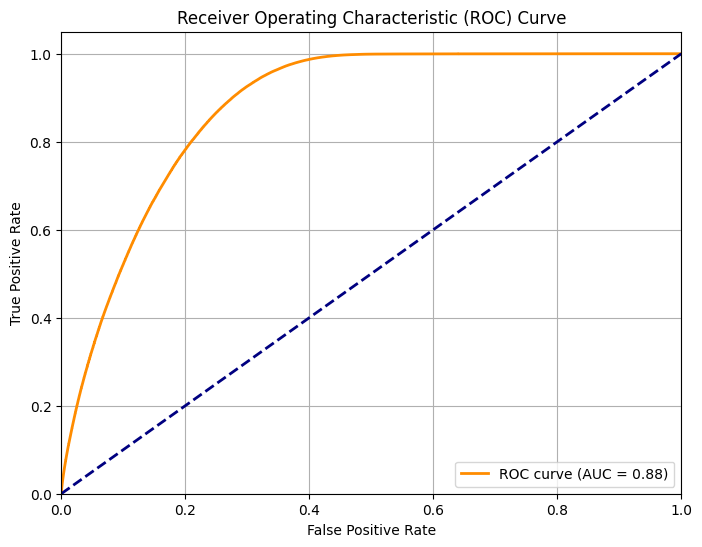

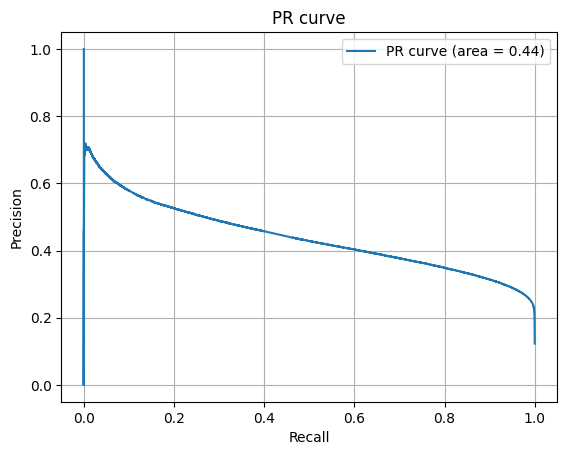

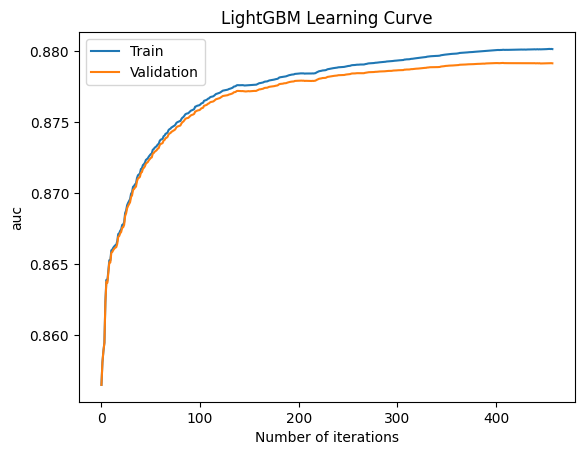

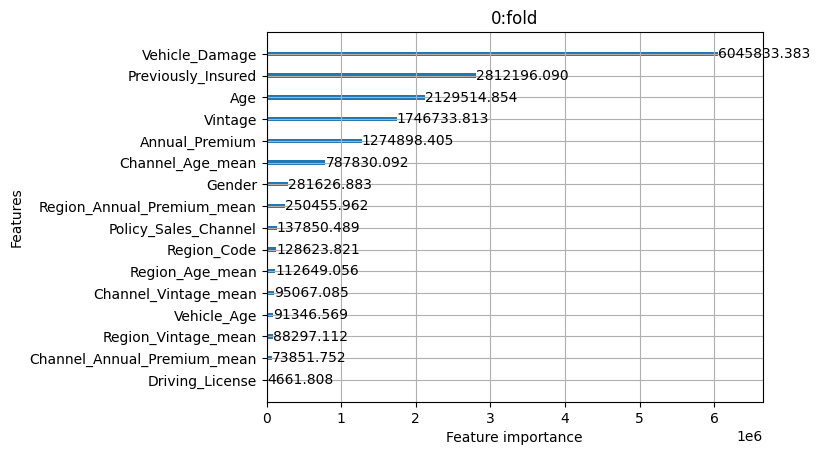

Fold 2
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.876221	valid's auc: 0.875827
[200]	train's auc: 0.878635	valid's auc: 0.878012
[300]	train's auc: 0.879495	valid's auc: 0.878666
Early stopping, best iteration is:
[339]	train's auc: 0.879637	valid's auc: 0.878739
AUC: 0.8787
Fold 3
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.876236	valid's auc: 0.876129
[200]	train's auc: 0.878174	valid's auc: 0.877919
[300]	train's auc: 0.879078	valid's auc: 0.878629
[400]	train's auc: 0.879934	valid's auc: 0.87927
[500]	train's auc: 0.880432	valid's auc: 0.879556
[600]	train's auc: 0.880709	valid's auc: 0.879667
Early stopping, best iteration is:
[558]	train's auc: 0.88071	valid's auc: 0.879716
AUC: 0.8797
Fold 4
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.876217	valid's auc: 0.875789
[200]	train's auc: 0.878501	valid's auc: 0.877941
[300]	train's auc: 0.879183	valid's auc: 0.878452
Earl

In [25]:
params = {
'objective': 'binary',
'metric': 'auc',
'boosting_type': 'gbdt',
'max_depth': 15,
'learning_rate': 0.1,
'feature_fraction': 0.9,
"n_estimators":10000,
#'scale_pos_weight': df_train["Response"].mean(),
'verbose': -1, 
'seed': 42
}


# params = {
# 'objective': 'binary',
# 'metric': 'auc',
# 'boosting_type': 'gbdt',
# 'max_depth': 16, 
# 'min_child_samples': 494, 
# 'min_split_gain': 0.001169,
# 'feature_fraction': 0.646383,
# 'bagging_fraction': 0.963269,
# 'learning_rate': 0.1,
# "n_estimators":1000,
# 'verbose': -1, 
# 'device': 'gpu',
# 'seed': 42
# }
# アウトオブフォールド予測の取得
oof_train,oof_test,oof_model = get_out_of_fold_predictions(X,y,test_x,params,n_splits=2)

In [26]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_segment,Annual_Premium_segment,Region_Age_mean,Channel_Age_mean,Region_Annual_Premium_mean,Channel_Annual_Premium_mean,Region_Vintage_mean,Channel_Vintage_mean
0,11504798,0,20,1,47,0,1,0,2630,152,228,20,1,34.011796,23.660296,29619.946622,23940.534729,163.806271,162.603648
1,11504799,1,47,1,28,0,0,1,37483,119,123,40,0,45.739382,46.573413,39568.122734,31845.418885,163.370570,162.184641
2,11504800,1,47,1,43,0,0,1,2630,25,271,40,1,38.165581,50.349448,23266.636883,34206.555898,163.161395,163.018388
3,11504801,0,22,1,47,1,1,0,24502,144,115,20,0,34.011796,25.999855,29619.946622,31394.315498,163.806271,166.329033
4,11504802,1,51,1,19,0,0,0,34115,119,148,50,0,41.947842,46.573413,24191.147828,31845.418885,165.750415,162.184641


In [ ]:
# import joblib
# joblib.dump(oof_model, 'lightgbm_model_baseline.pkl')

In [ ]:
# import shap
# shap.initjs()

# explainer = shap.TreeExplainer(model=oof_model, model_output="raw",feature_perturbation='tree_path_dependent')
# shap_values = explainer.shap_values(X=X)
# #shap.summary_plot(shap_values, X)
# shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X, feature_names=X.columns)
#shap.waterfall_plot(shap_explanation[0])

In [62]:
df_oof_train=pd.DataFrame(oof_train,columns=["y_pred_lgbm"])
# df_oof_train.to_csv(r"y_pred_train_lgbm_under_sample.csv")

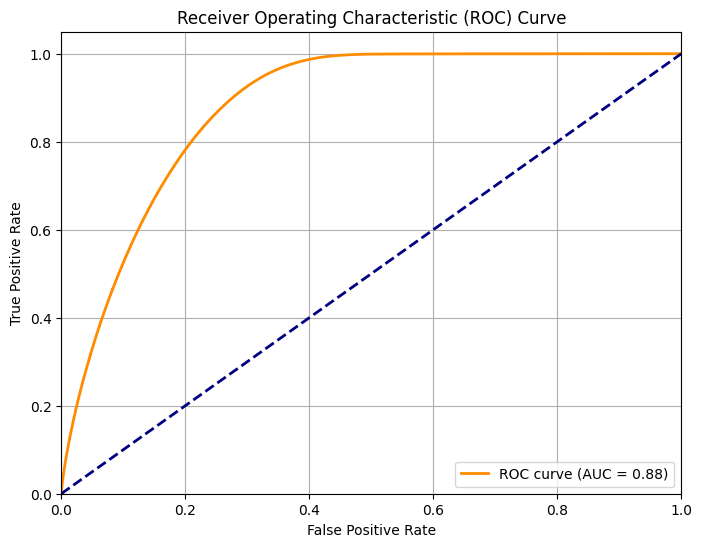

In [61]:
fpr, tpr, thresholds = roc_curve(df_train["Response"], df_oof_train["y_pred_lgbm"])
# AUCを計算
roc_auc = auc_calc(fpr, tpr)
# ROC曲線をプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

0.44102099673144324


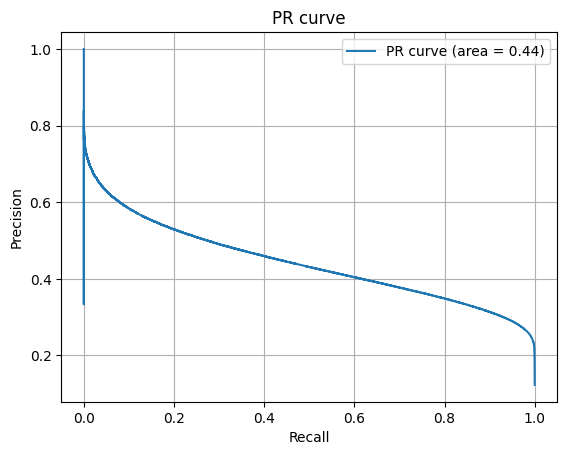

In [60]:
precision, recall, thresholds = precision_recall_curve(df_train["Response"], df_oof_train["y_pred_lgbm"])

auc = auc_calc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
# X_copy=X.copy()
# for col in X.columns:
#     if col not in encoder_list.keys():
#         continue
#     X_copy[col]=encoder_list[col].inverse_transform(X_copy[col])
# # base_line=pd.concat([X_copy,df_oof_train,y],axis=1)
# # ####base_line.to_csv(r"y_pred_train_lgbm_baseline.csv",index=False)

In [57]:
# df_oof_test=pd.DataFrame(np.mean(oof_test,axis=1),columns=["y_pred_lgbm"])
# df_oof_test=pd.merge(test["id"],df_oof_test,left_index=True,right_index=True)
# df_oof_test.to_csv(r"y_pred_test_lgbm_under_sample.csv",index=False)

# ハイパーパラメータチューニング

In [28]:

# import optuna

# X_optuna=X.copy()
# y_optuna=y.copy()

# # Objective関数の定義
# def objective(trial,    n_splits=2):
#     params_optuna = {
#         'objective': 'binary',
#         'metric': 'auc',  # AUCを評価指標として設定
#         'boosting_type': 'gbdt',
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 1000),
#         'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 10),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1),
#         "n_estimators":500,
#         'learning_rate': 0.1,
#         'verbose': -1
#     }
#     aucs = []
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     # 各分割のデータインデックスを出力
#     for fold, (train_idx, val_index) in enumerate(skf.split(X_optuna, y_optuna)):
#         print(f"Fold {fold + 1}")
#         # データを分割
#         X_train, X_val = X_optuna.iloc[train_idx], X_optuna.iloc[val_index]
#         y_train, y_val = y_optuna.iloc[train_idx], y_optuna.iloc[val_index]
#         # train_data = lgb.Dataset(X_train, label=y_train)
#         # val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
#         # LGBMClassifierの初期化
        
#         evals_result = {} 
#         model = LGBMClassifier(**params_optuna, importance_type='gain')
#         # モデルのトレーニング
#         model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)],eval_names=["train","valid"],eval_metric='auc',callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]) 
#         # モデルのトレーニング
#         y_pred = model.predict_proba(X_val)[:,1]
#         # 精度の計算
#         auc = roc_auc_score(y_val, y_pred)
#         print(f'AUC: {auc:.4f}')
#         aucs.append(auc)
#     return np.mean(aucs)

# # Optunaでハイパーパラメータの最適化を実行
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)
# # 最適化されたハイパーパラメータを取得
# best_params = study.best_params

{'max_depth': 16, 'min_child_samples': 494, 'min_split_gain': 0.0011694510917550532, 'feature_fraction': 0.6463830121644178, 'bagging_fraction': 0.9632692506318887}